In [ ]:
import json
from rdkit import Chem
import pandas as pd

DATA_PATH = '../../data/B-create-dataset/multi-chain-all-biolip-ligands'
DATASET_PATH = f'{DATA_PATH}/dataset.json'
BIOLIP_LIGANDS_PATH = f'{DATA_PATH}/ligand.tsv'

def get_ligand_atom_count(smiles):
    # hint: https://chemistry.stackexchange.com/questions/43363/how-to-calculate-hydrogen-from-smiles-string

    for i in str(smiles.values[0]).split(';'):
        i = i.strip()
        try:
            molecule = Chem.MolFromSmiles(i)
            atoms_count = molecule.GetNumHeavyAtoms()
            return atoms_count, i
        except:
            continue
    return -1, -1

def get_ligand_lengths(dataset_path, ligands_path):
    ligands_df = pd.read_csv(ligands_path, sep='\t')
    
    with open(dataset_path, 'r') as f:
        ds = json.load(f)

    structures = []

    for apo_key, holo_structures in ds.items():
        for holo_structure in holo_structures:
            structure = {}
            structure['apo_structure'] = apo_key + holo_structure['apo_chain']
            structure['holo_structure'] = holo_structure['holo_pdb_id'] + holo_structure['holo_chain']
            ligand = holo_structure['ligand']
            structure['ligand'] = ligand
            atoms_count, smiles = get_ligand_atom_count(ligands_df[ligands_df['#CCD'] == ligand]['SMILES'])
            if atoms_count == -1:
                continue
            structure['ligand_heavy_atom_count'], structure['ligand_smiles'] = atoms_count, smiles
            structures.append(structure)
    return pd.DataFrame(structures)

ligand_lengths = get_ligand_lengths(DATASET_PATH, BIOLIP_LIGANDS_PATH)


In [2]:
ligand_lengths = ligand_lengths.sort_values(by=['ligand_heavy_atom_count', 'ligand'], ascending=False)

ligand_lengths.to_csv('./data/ligand_length.csv')

Text(0, 0.5, '# of ligands')

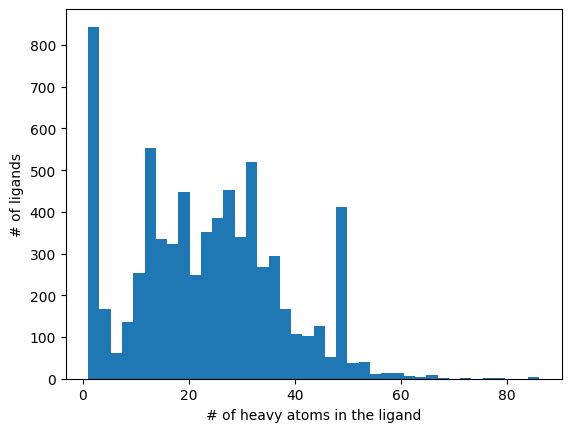

In [3]:
import matplotlib.pyplot as plt
plt.hist(ligand_lengths['ligand_heavy_atom_count'], bins=40)  # density=False would make counts
plt.xlabel('# of heavy atoms in the ligand')
plt.ylabel('# of ligands')


### drop duplicated ligands

In [14]:
print(len(ligand_lengths[ligand_lengths['ligand_heavy_atom_count'] <= 5]))
print(len(ligand_lengths))

print(len(ligand_lengths[ligand_lengths['ligand_heavy_atom_count'] > 5]['apo_structure'].unique()))
print(len(ligand_lengths['apo_structure'].unique()))

1012
7090
954
1257


In [5]:
ligand_lengths.drop_duplicates('ligand', inplace = True)

ligand_lengths.to_csv('./data/unique_ligand_length.csv')